<a href="https://colab.research.google.com/github/VishalKushwaha-godPlay/FDS-LABwork/blob/main/ADS_LAB_ASSIGNMENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
#Import all required packages:
import warnings
warnings.filterwarnings("ignore")
import os
import itertools
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 5

There are several categories in the Superstore sales data, I start from time series analysis and forecasting for Technology sales.

We have a good 4-year furniture sales data.

In [31]:
location=("/usr/Superstore.xls")
data_original = pd.read_excel(location)
data_original.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [32]:
data_original.shape

(9994, 21)

In [33]:
# categories of sales data
data_original.Category.value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

In [34]:
# copy only the rows related to category = Technology
Technology = data_original.loc[data_original['Category'] == 'Technology']
Technology.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.152,6,0.2,90.7152
11,12,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002033,Technology,Phones,Konftel 250 Conference phone - Charcoal black,911.424,4,0.2,68.3568
19,20,CA-2014-143336,2014-08-27,2014-09-01,Second Class,ZD-21925,Zuschuss Donatelli,Consumer,United States,San Francisco,California,94109,West,TEC-PH-10001949,Technology,Phones,Cisco SPA 501G IP Phone,213.480,3,0.2,16.0110
26,27,CA-2016-121755,2016-01-16,2016-01-20,Second Class,EH-13945,Eric Hoffmann,Consumer,United States,Los Angeles,California,90049,West,TEC-AC-10003027,Technology,Accessories,Imation 8GB Mini TravelDrive USB 2.0 Flash Drive,90.570,3,0.0,11.7741
35,36,CA-2016-117590,2016-12-08,2016-12-10,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,Texas,75080,Central,TEC-PH-10004977,Technology,Phones,GE 30524EE4,1097.544,7,0.2,123.4737


In [35]:
# data_original range
Technology['Order Date'].min(), Technology['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# **Data Exploration:**
This step includes removing columns we do not need, check missing values, aggregate sales by date and so on

In [36]:
Technology.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [37]:
# columns to drop
cols = ['Row ID', 
        'Order ID', 
        'Ship Date', 
        'Ship Mode', 
        'Customer ID', 
        'Customer Name', 
        'Segment', 
        'Country', 
        'City', 
        'State', 
        'Postal Code', 
        'Region', 
        'Product ID', 
        'Category', 
        'Sub-Category', 
        'Product Name', 
        'Quantity', 
        'Discount', 
        'Profit']

Technology.drop(cols, axis=1, inplace=True)

In [38]:
Technology.sort_values('Order Date', inplace=True)
# check for null values
Technology.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [39]:
Technology.columns
# Lets check if we have more than one sales data for a date:
temp = Technology.groupby('Order Date')['Sales'].size() 
temp[temp > 1].sort_values(ascending=False)

Order Date
2017-09-24    10
2017-07-03     9
2017-11-13     8
2017-11-12     8
2016-11-24     8
              ..
2016-05-05     2
2016-04-19     2
2016-04-16     2
2016-04-15     2
2014-01-06     2
Name: Sales, Length: 473, dtype: int64

In [15]:
# aggregate sales by date
Technology = Technology.groupby('Order Date')['Sales'].sum().reset_index()
# Indexing with Time Series Data
Technology = Technology.set_index('Order Date')
print(Technology.index)
print(Technology.sample(10))

DatetimeIndex(['2014-01-06', '2014-01-09', '2014-01-13', '2014-01-15',
               '2014-01-16', '2014-01-20', '2014-01-26', '2014-02-01',
               '2014-02-02', '2014-02-06',
               ...
               '2017-12-18', '2017-12-21', '2017-12-22', '2017-12-23',
               '2017-12-24', '2017-12-25', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=824, freq=None)
               Sales
Order Date          
2015-06-21   107.976
2015-07-25   623.960
2014-03-19   494.216
2014-04-28  1839.940
2016-04-28   369.576
2016-03-09   199.750
2016-07-25  1861.776
2014-05-26   285.568
2016-09-29  1105.410
2015-05-10    46.688


<Figure size 1152x432 with 0 Axes>

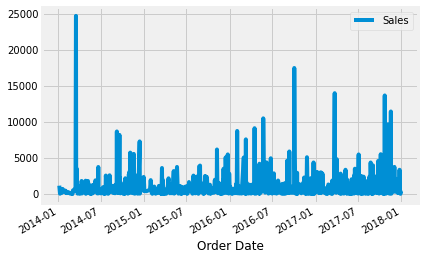

In [16]:
plt.figure(figsize=(16, 6));
Technology.plot();

DatetimeIndex can be used for the individual date/time components are all available as attributes such as year, month, day, and so on.

In [21]:
# Add columns with year, month, and weekday name
Technology['Year']         = pd.DatetimeIndex(Technology.index).year
Technology['Month']        = pd.DatetimeIndex(Technology.index).month

# Display a random sampling of 5 rows
Technology.sample(10, random_state=0)

,Sales,Year,Month
Order Date,,,
2014-07-23,2555.084,2014,7
2014-03-28,302.376,2014,3
2014-02-02,180.960,2014,2
2015-10-20,239.970,2015,10
2017-12-27,164.388,2017,12
2017-10-05,5520.506,2017,10
2017-07-21,2180.644,2017,7
2015-09-03,247.840,2015,9
2015-12-18,166.240,2015,12


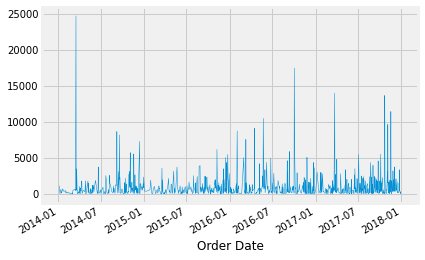

In [22]:
# create a line plot of the full time series of daily sales, 
# using the DataFrame’s plot() method.
Technology['Sales'].plot(linewidth=0.5);

# **Checking for seasonality**

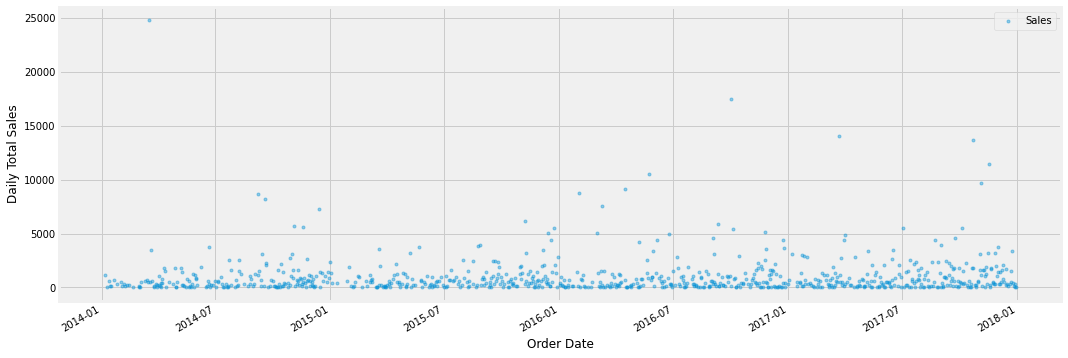

In [23]:
# Use seaborn style defaults and set the default figure size
# sns.set(rc={'figure.figsize':(18, 6)})

cols_plot = ['Sales']

axes      = Technology[cols_plot].plot(marker='.',
                                       alpha=0.4, 
                                       linestyle='None', 
                                       figsize=(16, 6), 
                                       subplots=True)

for ax in axes:
    ax.set_ylabel('Daily Total Sales')

**Checking Seasonality using Box-Plots:**

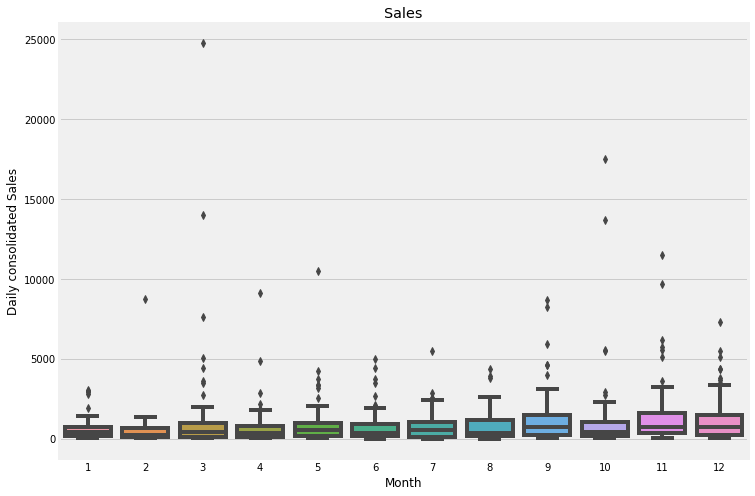

In [24]:
fig, ax = plt.subplots(figsize=(11, 8))

sns.boxplot(data=Technology, x='Month', y='Sales', ax=ax)

ax.set_title('Sales')

ax.set_ylabel('Daily consolidated Sales');

Now we try to plot the graph by the year starting from 2014 to 2017

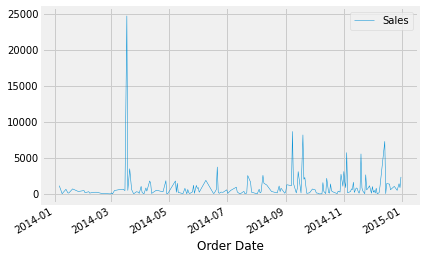

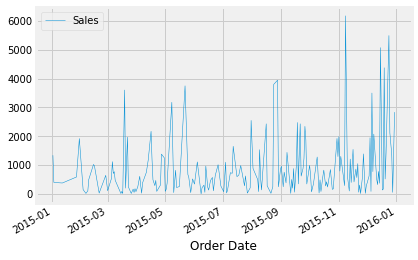

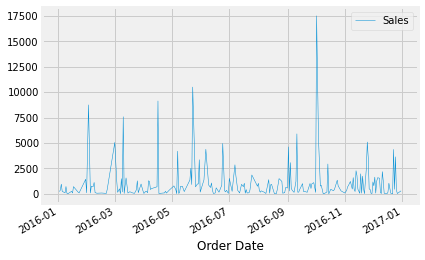

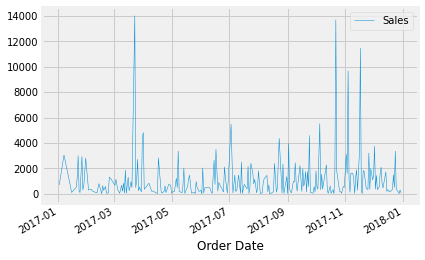

In [25]:
cols_plot = ['Sales']

Technology.loc['2014'][cols_plot].plot(linewidth=0.5);
Technology.loc['2015'][cols_plot].plot(linewidth=0.5);
Technology.loc['2016'][cols_plot].plot(linewidth=0.5);
Technology.loc['2017'][cols_plot].plot(linewidth=0.5);

**observation:**

1.the trend, seasonality is not obvious from the above plots, as there are a lots of data points.

2.There seems to indication of seasonality at the end of the year 2015 and 2017, but we can not see the certain seasonality.

3.we can roll-up the data, weekly & monthly and then re-plot

# **sales - Monthly resampling**

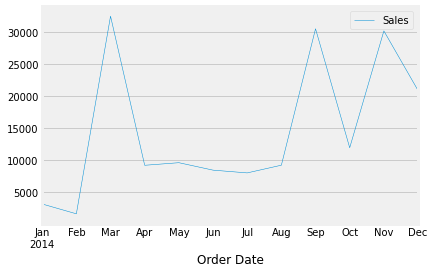

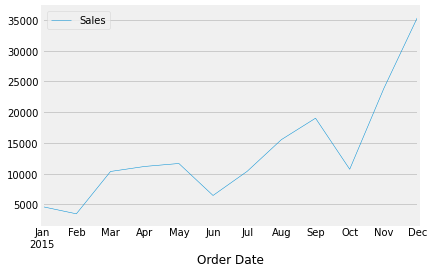

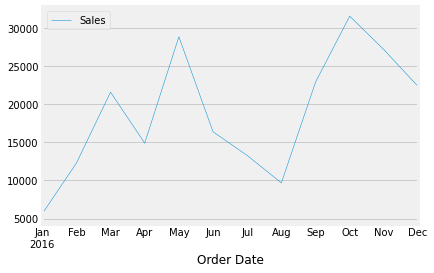

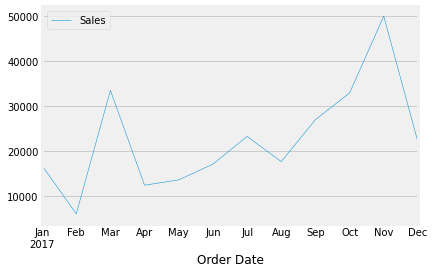

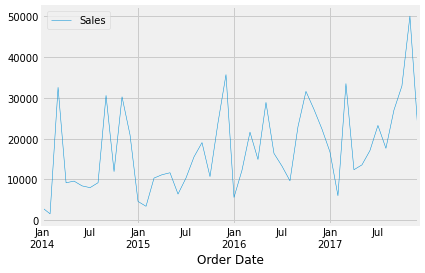

In [26]:
# monthly sales
data_columns = ['Sales']

# Resample to weekly frequency, aggregating with mean
Technology_monthly = Technology[data_columns].resample('M').sum()
Technology_monthly.head(3)

cols_plot = ['Sales']

Technology_monthly.loc['2014'][cols_plot].plot(linewidth=0.5);
Technology_monthly.loc['2015'][cols_plot].plot(linewidth=0.5);
Technology_monthly.loc['2016'][cols_plot].plot(linewidth=0.5);
Technology_monthly.loc['2017'][cols_plot].plot(linewidth=0.5);
Technology_monthly[cols_plot].plot(linewidth=0.5);

**observation**

1.Every year, there is slight uptrend visible

2.sales up in the months of Sep-Oct-Nov

3.Consolidated 4 years - slight uptrend in sales numbers

4.sales picks up in the last QTR of every calender year(Except December), indicates seasonality

# **Stationary test**
1.Data points are often non-stationary or have means, variances and covariances that change over time.

2.Non-stationary behaviors can be trends, cycles, random walks or combinations of the three.

3.Non-stationary data, as a rule, are unpredictable and cannot be modeled or forecasted.



Stationarity test : Method 1 : Plots

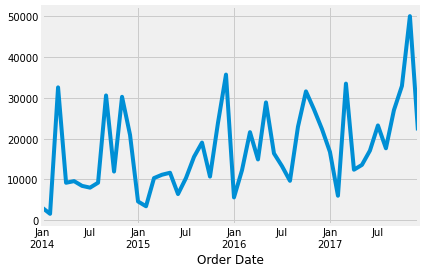

In [27]:
Technology_monthly['Sales'].plot();

Stationarity test : Method 2 : Summary Statistics

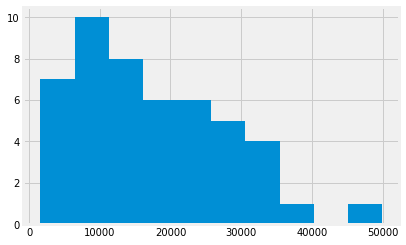

In [28]:
Technology_monthly['Sales'].hist();

In [29]:
X = Technology_monthly['Sales'].values
split = len(X) / 2
split = int(split)

X1, X2 = X[0:split], X[split:]

mean1, mean2 = X1.mean(), X2.mean()
var1,  var2  = X1.var(),  X2.var()

print('mean1     = {:10.2f}, mean2     = {:10.2f}'.format(mean1, mean2))
print('variance1 = {:10.2f}, variance2 = {:10.2f}'.format(var1,  var2))

mean1     =   14085.79, mean2     =   20753.96
variance1 = 93096702.63, variance2 = 97720479.23


-the mean and variance values are different. But in the same ball-park range.

-Hence the time series is stationary